# Credit Card Dataset Clustering with PySpark

This case requires the development of a customer segmentation to define a marketing strategy. The
sample Dataset summarises the usage behaviour of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

The data was obtained from Kaggle: https://www.kaggle.com/arjunbhasin2013/ccdata

Dataset features are as follow:    
CUSTID : Identification of Credit Card holder (Categorical)     
BALANCE : Balance amount left in their account to make purchases     
BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)     
PURCHASES : Amount of purchases made from account    
ONEOFFPURCHASES : Maximum purchase amount done in one-go    
INSTALLMENTSPURCHASES : Amount of purchase done in installment    
CASHADVANCE : Cash in advance given by the user    
PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)     
ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)     
PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)      
CASHADVANCEFREQUENCY : How frequently the cash in advance being paid       
CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"     
PURCHASESTRX : Numbe of purchase transactions made         
CREDITLIMIT : Limit of Credit Card for user      
PAYMENTS : Amount of Payment done by user      
MINIMUM_PAYMENTS : Minimum amount of payments made by user       
PRCFULLPAYMENT : Percent of full payment paid by user       
TENURE : Tenure of credit card service for user         

This was used as an opportunity to implement PySpark with KMeans Clustering.

In [1]:
import os
import pandas as pd

os.environ["PYSPARK_PYTHON"]="python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3"

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

## Examining the data

In [2]:
#load data
data = spark.read.csv("CC GENERAL.csv",header=True,inferSchema=True)
data.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [3]:
#CUST_ID is the id column - not needed, so dropped 
drop_col = ['CUST_ID']
data = data.select([column for column in data.columns if column not in drop_col])

In [4]:
data.head().asDict()

{'BALANCE': 40.900749,
 'BALANCE_FREQUENCY': 0.818182,
 'PURCHASES': 95.4,
 'ONEOFF_PURCHASES': 0.0,
 'INSTALLMENTS_PURCHASES': 95.4,
 'CASH_ADVANCE': 0.0,
 'PURCHASES_FREQUENCY': 0.166667,
 'ONEOFF_PURCHASES_FREQUENCY': 0.0,
 'PURCHASES_INSTALLMENTS_FREQUENCY': 0.083333,
 'CASH_ADVANCE_FREQUENCY': 0.0,
 'CASH_ADVANCE_TRX': 0,
 'PURCHASES_TRX': 2,
 'CREDIT_LIMIT': 1000.0,
 'PAYMENTS': 201.802084,
 'MINIMUM_PAYMENTS': 139.509787,
 'PRC_FULL_PAYMENT': 0.0,
 'TENURE': 12}

### Null values

In [5]:
#check for any missing values
from pyspark.sql.functions import isnan, isnull, when, count, col

data.select([count(when(isnan(c)| isnull(c), c)).alias(c) for c in data.columns]).show()

+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+--------+----------------+----------------+------+
|      0|                0|        0|               0|                     0|           0|                  0|                         0

Not easy to see which columns have nulls. So the below function will be implemented to find the columns with null values and number of nulls.

In [6]:
#function to find more information about missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)         
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") 
    return mis_val_table_ren_columns

In [7]:
data_pd = data.toPandas()
missings = info_missing_table(data_pd)
missings

Your selected dataframe has 17 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MINIMUM_PAYMENTS,313,3.5
CREDIT_LIMIT,1,0.0


These nulls will be filled in with the mean of the remaining values in the column.

In [8]:
#fill missing numerical values with mean of each column
from pyspark.sql.functions import mean, round

null_cols = ['MINIMUM_PAYMENTS','CREDIT_LIMIT']

for i in null_cols:
    meanvalue = data.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    data=data.na.fill({i:meanvalue})

MINIMUM_PAYMENTS 864.0
CREDIT_LIMIT 4494.0


In [9]:
data_pd = data.toPandas()
missings = info_missing_table(data_pd)
missings

Your selected dataframe has 17 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [10]:
#summary of data
data.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
BALANCE,8950,1564.4748276781038,2081.531879456551,0.0,19043.13856
BALANCE_FREQUENCY,8950,0.8772707255865991,0.23690400268476833,0.0,1.0
PURCHASES,8950,1003.2048335195564,2136.6347818728905,0.0,49039.57
ONEOFF_PURCHASES,8950,592.437370949722,1659.8879174378076,0.0,40761.25
INSTALLMENTS_PURCHASES,8950,411.06764469273713,904.3381151753807,0.0,22500.0
CASH_ADVANCE,8950,978.8711124654749,2097.1638766432347,0.0,47137.21176
PURCHASES_FREQUENCY,8950,0.4903505483798885,0.4013707473690413,0.0,1.0
ONEOFF_PURCHASES_FREQUENCY,8950,0.20245768357542138,0.2983360651847189,0.0,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950,0.3644373415642452,0.39744777974541334,0.0,1.0


### Dealing with outliers

Due to the great variance in feature values, and a large number of outliers, values will be converted to range labels.

In [11]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import array, col, lit

columns=['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS']

splits = [float("-inf"), 500.0, 1000.0, 3000.0, 5000.0, 10000, float("inf")]
for col in columns:
    bucketizer = Bucketizer(
        splits=splits, inputCol=col, outputCol=col+"_RANGE"
    )
    data = bucketizer.transform(data)
    
data = data.select([column for column in data.columns if column not in columns])

In [12]:
columns=['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

splits = [float("-inf"), 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, float("inf")]

for col in columns:
    bucketizer = Bucketizer(
        splits=splits, inputCol=col, outputCol=col+"_RANGE"
    )
    data = bucketizer.transform(data)

data = data.select([column for column in data.columns if column not in columns])

In [13]:
columns=['PURCHASES_TRX', 'CASH_ADVANCE_TRX']  

splits = [float("-inf"), 5, 10, 15, 20, 30, 50, 100, float("inf")]

for col in columns:
    bucketizer = Bucketizer(
        splits=splits, inputCol=col, outputCol=col+"_RANGE"
    )
    data = bucketizer.transform(data)

data = data.select([column for column in data.columns if column not in columns])

In [14]:
data.toPandas()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE
0,12,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12,3.0,0.0,0.0,0.0,4.0,4.0,3.0,2.0,9.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
2,12,2.0,1.0,1.0,0.0,0.0,4.0,1.0,1.0,9.0,9.0,9.0,0.0,0.0,0.0,2.0,0.0
3,12,2.0,2.0,2.0,0.0,0.0,4.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,6,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,9.0,9.0,0.0,8.0,0.0,5.0,1.0,0.0
8946,6,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,9.0,9.0,0.0,8.0,0.0,0.0,1.0,0.0
8947,6,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,8.0,0.0,6.0,0.0,2.0,1.0,0.0
8948,6,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0


### Transforming the data

In [15]:
from pyspark.ml.feature import VectorAssembler

In [16]:
cols = data.columns

assembler = VectorAssembler(inputCols = cols, outputCol = 'features')

final_data = assembler.transform(data)

In [17]:
final_data.printSchema()

root
 |-- TENURE: integer (nullable = true)
 |-- BALANCE_RANGE: double (nullable = true)
 |-- PURCHASES_RANGE: double (nullable = true)
 |-- ONEOFF_PURCHASES_RANGE: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_RANGE: double (nullable = true)
 |-- CREDIT_LIMIT_RANGE: double (nullable = true)
 |-- PAYMENTS_RANGE: double (nullable = true)
 |-- MINIMUM_PAYMENTS_RANGE: double (nullable = true)
 |-- BALANCE_FREQUENCY_RANGE: double (nullable = true)
 |-- PURCHASES_FREQUENCY_RANGE: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY_RANGE: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY_RANGE: double (nullable = true)
 |-- PRC_FULL_PAYMENT_RANGE: double (nullable = true)
 |-- PURCHASES_TRX_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_TRX_RANGE: double (nullable = true)
 |-- features: vector (nullable = true)



### Scaling the data

In [18]:
from pyspark.ml.feature import StandardScaler

In [19]:
#scale with respect to standard deviation
scaler = StandardScaler(inputCol="features", 
                        outputCol="scaledFeatures", 
                        withStd=True, 
                        withMean=False)

In [20]:
#compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

In [21]:
#normalise each feature to have unit standard deviation.
cluster_final_data = scalerModel.transform(final_data)

In [22]:
#make sure it works
cluster_final_data.printSchema()

root
 |-- TENURE: integer (nullable = true)
 |-- BALANCE_RANGE: double (nullable = true)
 |-- PURCHASES_RANGE: double (nullable = true)
 |-- ONEOFF_PURCHASES_RANGE: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_RANGE: double (nullable = true)
 |-- CREDIT_LIMIT_RANGE: double (nullable = true)
 |-- PAYMENTS_RANGE: double (nullable = true)
 |-- MINIMUM_PAYMENTS_RANGE: double (nullable = true)
 |-- BALANCE_FREQUENCY_RANGE: double (nullable = true)
 |-- PURCHASES_FREQUENCY_RANGE: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY_RANGE: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY_RANGE: double (nullable = true)
 |-- PRC_FULL_PAYMENT_RANGE: double (nullable = true)
 |-- PURCHASES_TRX_RANGE: double (nullable = true)
 |-- CASH_ADVANCE_TRX_RANGE: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)

## Clustering

### Optimal number of clusters

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [24]:
# Trains a k-means model.
nums = list(range(2, 15))

for num in nums:
    kmeans = KMeans().setK(num).setSeed(1)
    model = kmeans.fit(cluster_final_data)

    #make predictions
    predictions = model.transform(cluster_final_data)

    #evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance with {} clusters = ".format(num) + str(silhouette))

Silhouette with squared euclidean distance with 2 clusters = 0.5396186461379415
Silhouette with squared euclidean distance with 3 clusters = 0.5115374026401014
Silhouette with squared euclidean distance with 4 clusters = 0.4820399063841269
Silhouette with squared euclidean distance with 5 clusters = 0.4290843899576289
Silhouette with squared euclidean distance with 6 clusters = 0.35534375623775283
Silhouette with squared euclidean distance with 7 clusters = 0.3671871296068023
Silhouette with squared euclidean distance with 8 clusters = 0.35730422530975187
Silhouette with squared euclidean distance with 9 clusters = 0.3988107777511289
Silhouette with squared euclidean distance with 10 clusters = 0.4109369961724321
Silhouette with squared euclidean distance with 11 clusters = 0.3909708742226161
Silhouette with squared euclidean distance with 12 clusters = 0.3912782882154243
Silhouette with squared euclidean distance with 13 clusters = 0.34692541672447846
Silhouette with squared euclidean

In [25]:
import numpy as np
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures").setPredictionCol("cluster")

    model = kmeans.fit(cluster_final_data)
    cost[k] = model.computeCost(cluster_final_data)

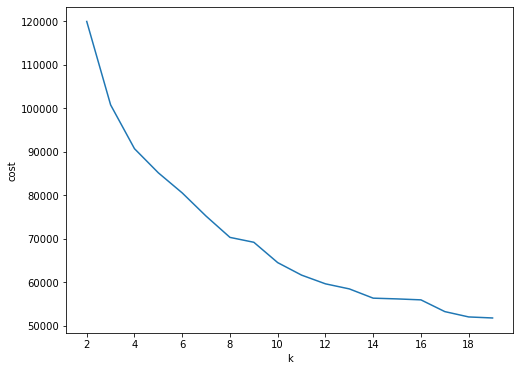

In [26]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From the above, a number of options exist. From the Silhouette scores, 2 clusters appear to be the best option. However, for such a diverse dataset, and with the goal of defining a marketing strategy to target different clusters of customers, a higher number of clusters would enable much more targeted marketing. 

For this reason, clustering was repeated where cost was considered. The above graph plots number of clusters and cost, with the purpose to select the 'elbow' (where the line shows the most abrupt transition from steep to flatter). From the above, a number of k values could be selected - 3, 4, 8, 10 and 14 appear to all be valid options. As it displays the largest contrast in terms of direction change, 8 clusters will be selected here. This may not be the optimal number of clusters for the purposes of marketing design, and this is where domain knowledge would come in; informed by awareness of customers and of the marketing departments goals and ideas it would be easier to determine how many clusters would be best suited.

### Creating the model

In [27]:
kmeans = KMeans(featuresCol='scaledFeatures', k=8)
model = kmeans.fit(cluster_final_data)
clusters = model.transform(cluster_final_data)

In [28]:
model.transform(cluster_final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  644|
|         6|  813|
|         3| 1429|
|         5| 1073|
|         4| 1037|
|         7| 1117|
|         2|  746|
|         0| 2091|
+----------+-----+



This seems to be a fairly good distribution of clusters; although there are some clusters with a much larger number of customers than others, there is no cluster with an insignificant number of customers.

## Cluster interpretation

In [29]:
df_clusters = clusters.toPandas()
df_clusters.drop(['features','scaledFeatures'], axis=1, inplace=True)
df_clusters.head()

,TENURE,BALANCE_RANGE,PURCHASES_RANGE,ONEOFF_PURCHASES_RANGE,INSTALLMENTS_PURCHASES_RANGE,CASH_ADVANCE_RANGE,CREDIT_LIMIT_RANGE,PAYMENTS_RANGE,MINIMUM_PAYMENTS_RANGE,BALANCE_FREQUENCY_RANGE,PURCHASES_FREQUENCY_RANGE,ONEOFF_PURCHASES_FREQUENCY_RANGE,PURCHASES_INSTALLMENTS_FREQUENCY_RANGE,CASH_ADVANCE_FREQUENCY_RANGE,PRC_FULL_PAYMENT_RANGE,PURCHASES_TRX_RANGE,CASH_ADVANCE_TRX_RANGE,prediction
0,12,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,12,3.0,0.0,0.0,0.0,4.0,4.0,3.0,2.0,9.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,5
2,12,2.0,1.0,1.0,0.0,0.0,4.0,1.0,1.0,9.0,9.0,9.0,0.0,0.0,0.0,2.0,0.0,4
3,12,2.0,2.0,2.0,0.0,0.0,4.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,12,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


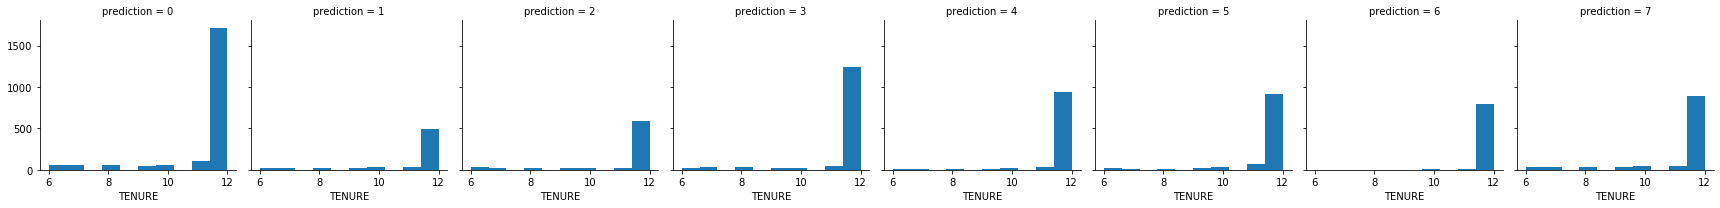

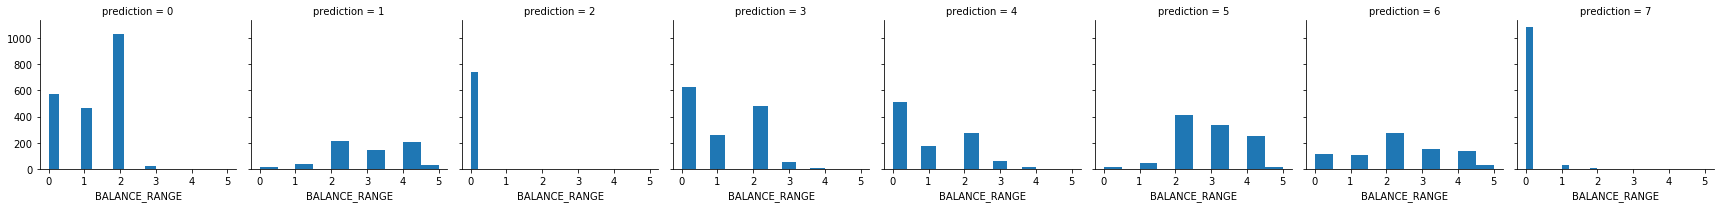

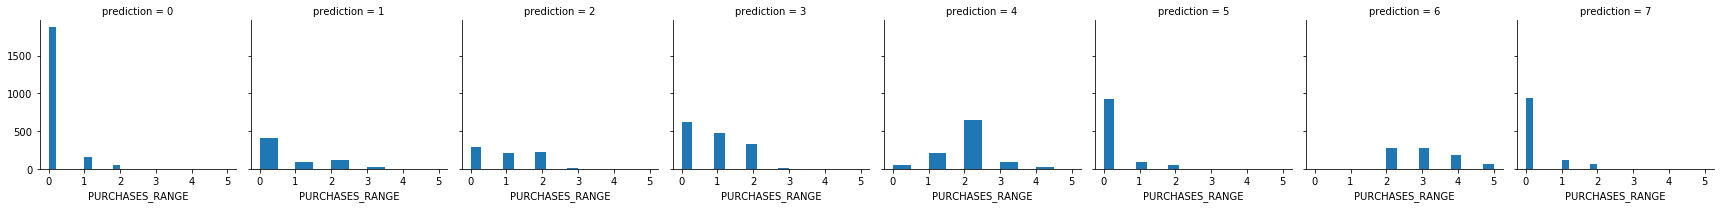

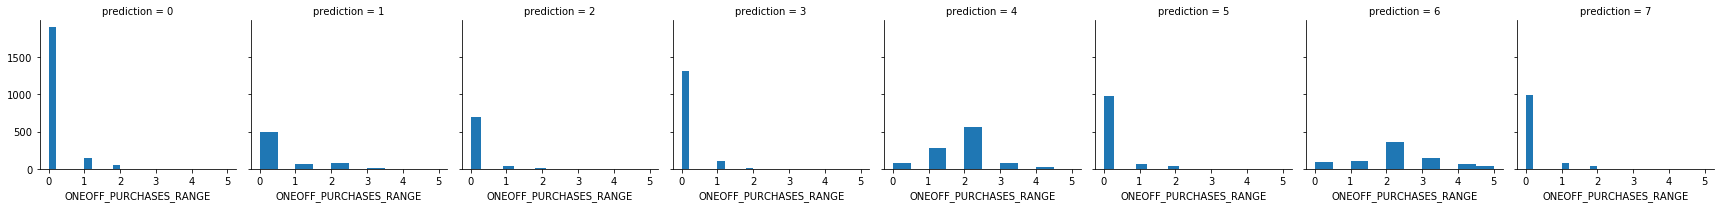

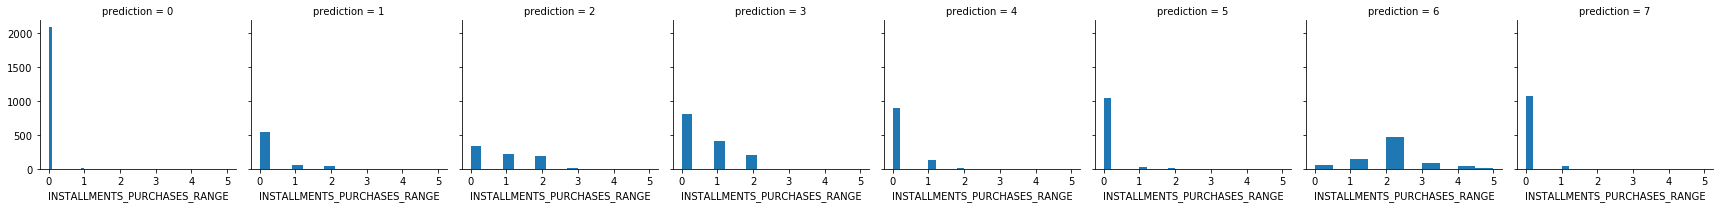

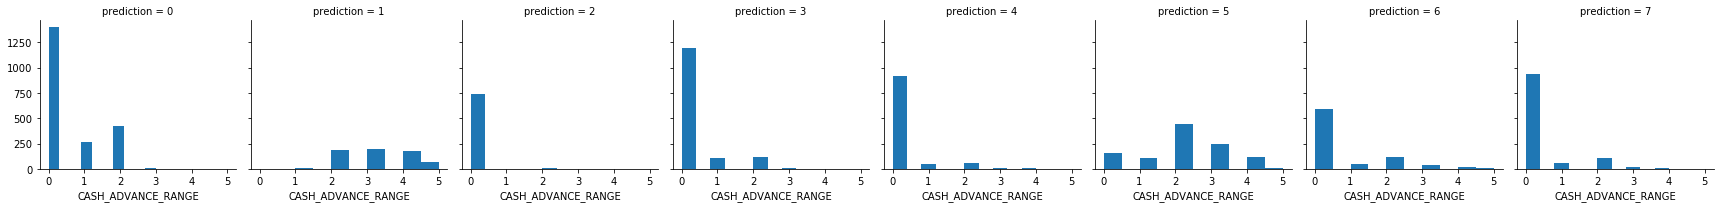

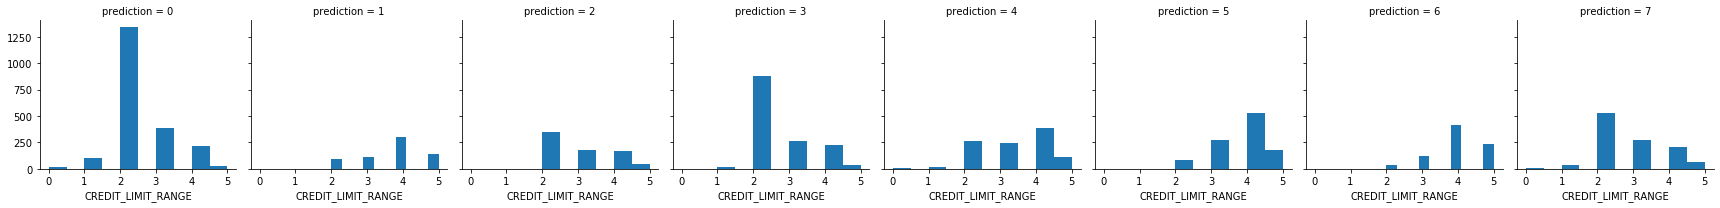

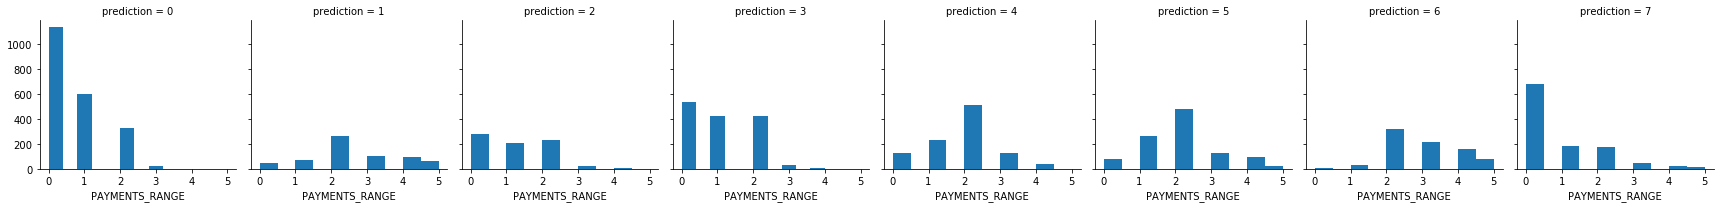

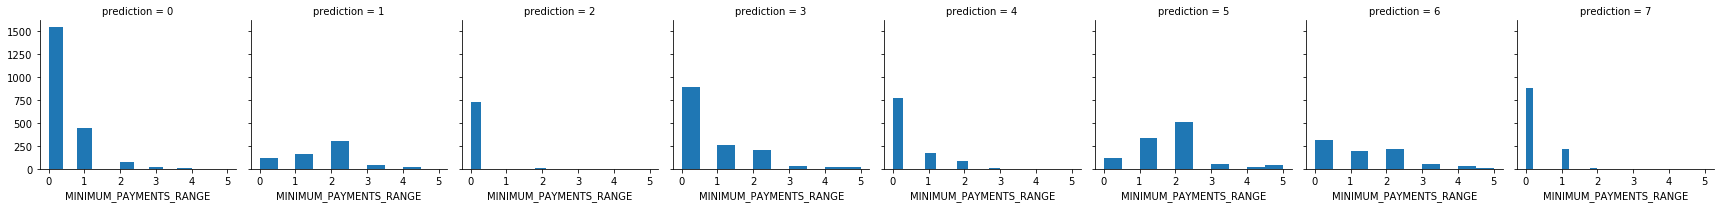

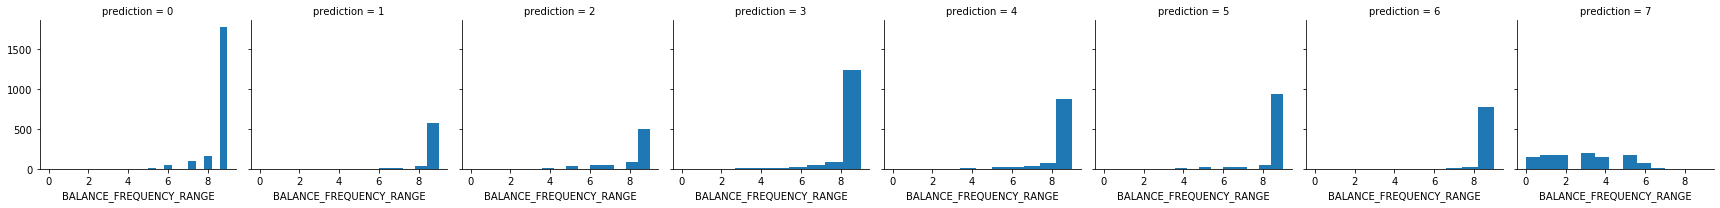

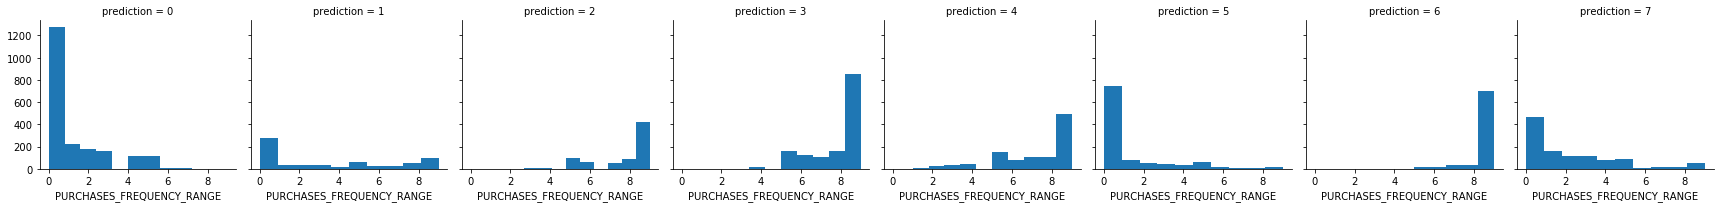

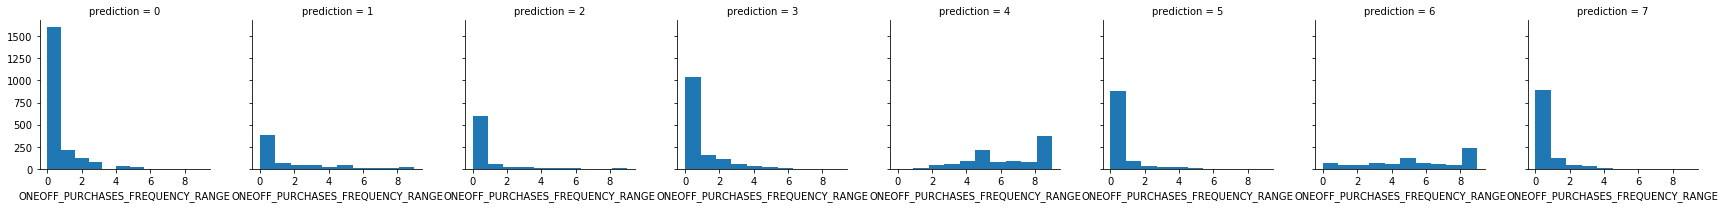

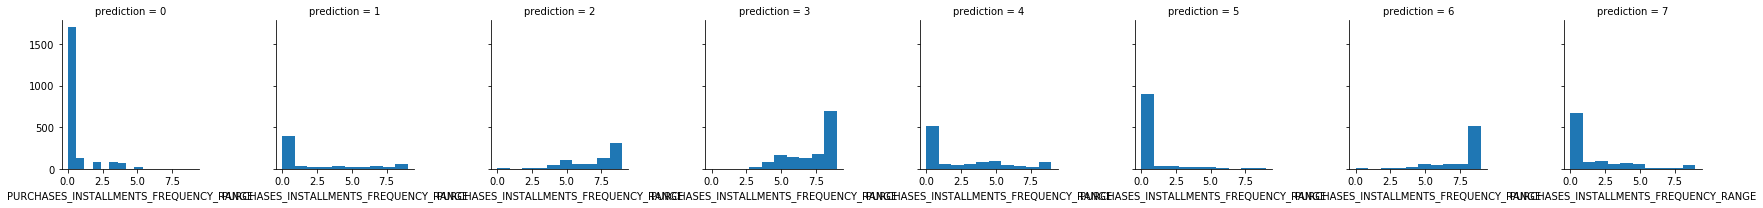

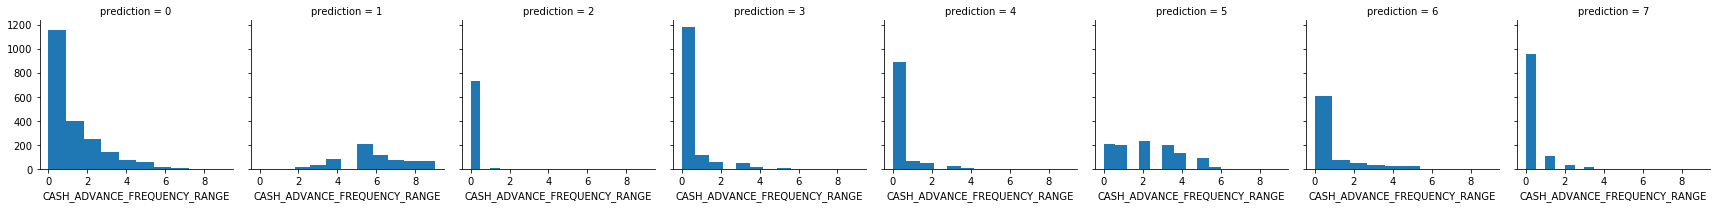

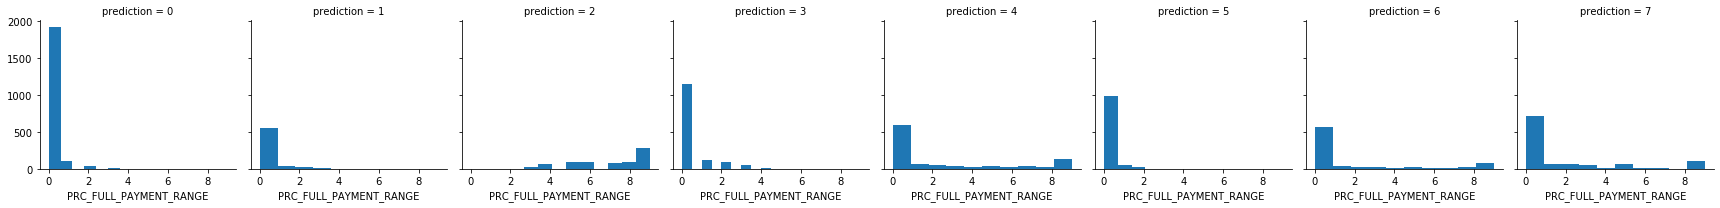

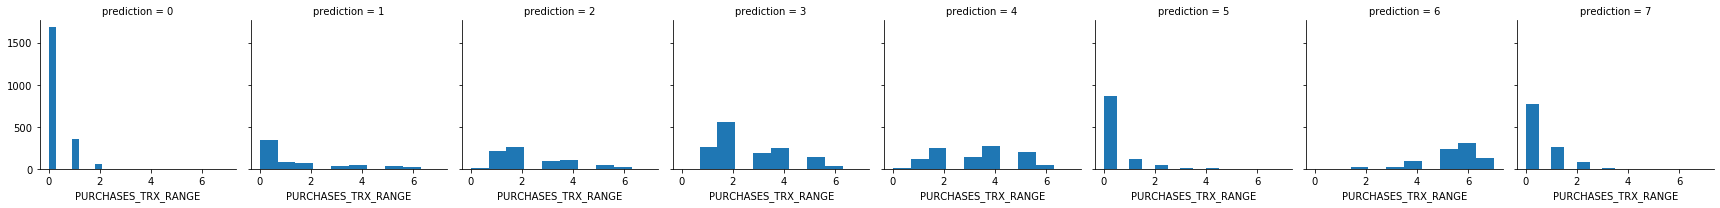

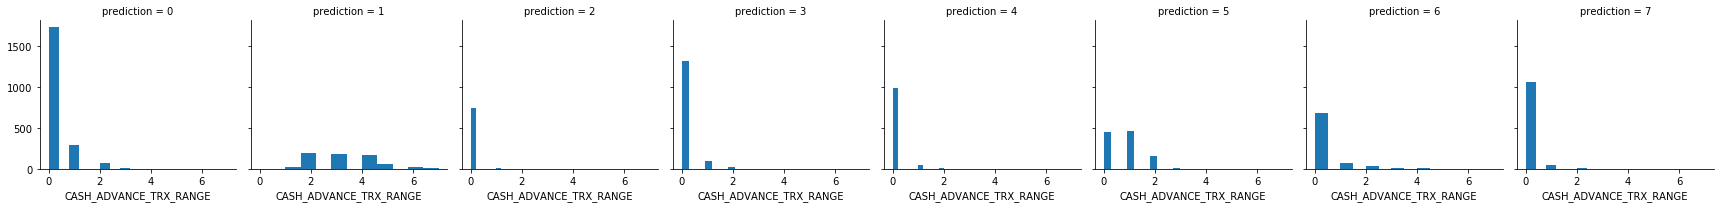

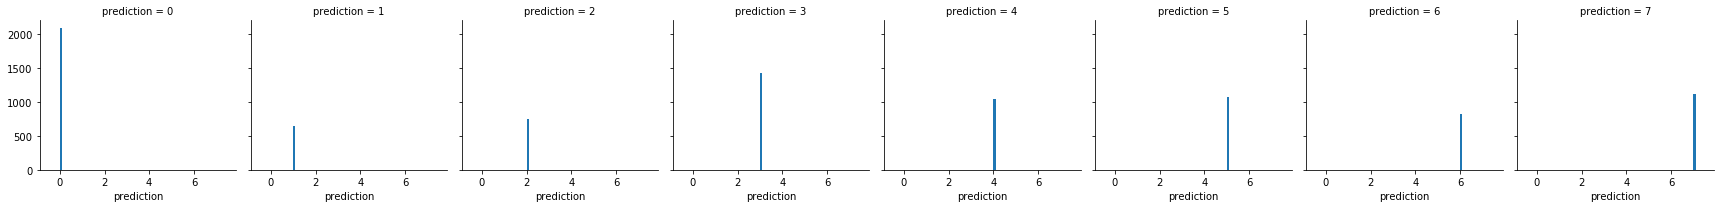

In [30]:
import seaborn as sns

for c in df_clusters:
    grid= sns.FacetGrid(df_clusters, col='prediction')
    grid.map(plt.hist, c)

Clusters characterised:       
0: medium balance and credit limit, high balance frequency    
1: medium cash advance trx, high cash advance    
2: high prc full payment    
3: high purchase frequency and installments, low payments    
4: high oneoff purchase frequency   
5: high credit limit and balance   
6: high purchases trx   
7: low balance frequency   

## Visualisation of clusters with PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [32]:
X = df_clusters.drop(['prediction'], axis=1)
X = np.asarray(X)

dist = 1 - cosine_similarity(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

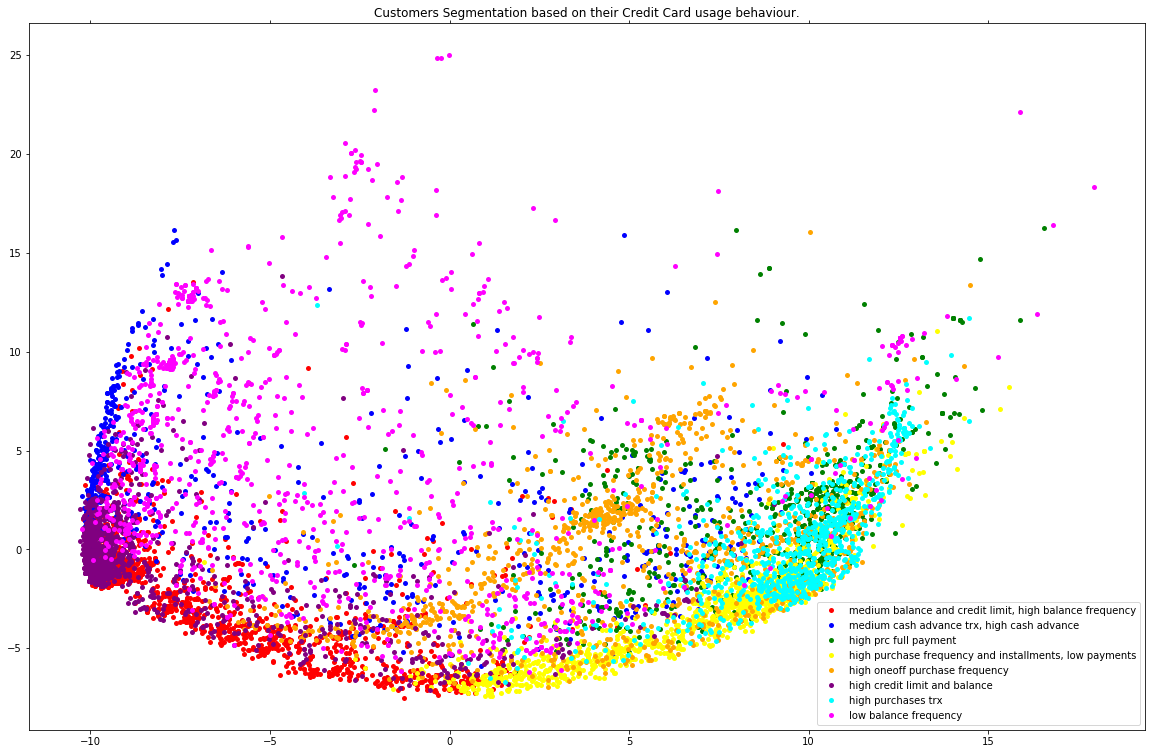

In [33]:
x, y = X_PCA[:, 0], X_PCA[:, 1]
labels = df_clusters['prediction'].values
colors = {
    0: 'red',
    1: 'blue',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'cyan',
    7: 'magenta'
}

names = {
    0: 'medium balance and credit limit, high balance frequency', 
    1: 'medium cash advance trx, high cash advance',
    2: 'high prc full payment',
    3: 'high purchase frequency and installments, low payments',
    4: 'high oneoff purchase frequency',
    5: 'high credit limit and balance',
    6: 'high purchases trx',
    7: 'low balance frequency'
}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage behaviour.")
plt.show()